In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def bar_plot(mix_data, est_data, mvng_est_data, x_axis_lst, ylabel, title, bar_plot_labels = ['mix', 'est', 'moving_est']):
        barWidth = 0.25
        
        br1 = np.arange(len(mix_data))
        br2 = [x + barWidth for x in br1]
        br3 = [x + barWidth for x in br2]
        plt.figure()
        plt.bar(br1, mix_data, color ='b', width = barWidth,
                edgecolor ='grey', label = bar_plot_labels[0])
        plt.bar(br2, est_data, color ='g', width = barWidth,
                edgecolor ='grey', label =bar_plot_labels[1])
        plt.bar(br3, mvng_est_data, color ='r', width = barWidth,
                edgecolor ='grey', label =bar_plot_labels[2])

        plt.xticks( [r + barWidth for r in range(len(mix_data))],
                x_axis_lst)
        plt.xlabel('t60')
        plt.ylabel(ylabel)
        plt.legend()
        plt.title(title)

        data_lim = [mix_data, est_data, mvng_est_data]
        min_val = round(np.min(data_lim), 2)
        max_val = round(np.max(data_lim), 2)
        #plt.yticks(np.arange(min_val-0.02, max_val+0.02, step=0.02))
        #plt.ylim([min_val-0.02, max_val+ 0.02])
        #print(min_val, max_val)
        metric = ylabel
        if "snr" in metric:
                plt.ylim([min_val-1, max_val+1])
        elif "pesq" in metric:
                plt.yticks(np.arange(min_val-0.5, max_val+0.5, step=0.1))
                plt.ylim([min_val-0.2, max_val+0.2])
        elif "stoi" in metric:
                
                plt.yticks(np.arange(min_val-0.5, max_val+0.5, step=1))
                plt.ylim([min_val-0.1, max_val+ 0.1])
        elif "frm_Acc" in metric or "blk_Acc" in metric:
                plt.yticks(np.arange(min_val-0.5, max_val+0.5, step=5))
                plt.ylim([min_val-0.1, max_val+ 0.1])

In [3]:
def get_metrics(exp_dict, mic_idx, train, var_list, var2, metric, dataset_condition, comparison_domain, scenarios, model_type):
    #Getting list of each case
    mix_metrics = []
    enh_metrics = []
    mvng_enh_metrics = []
    mvng_mix_metrics = []


    for var in var_list:
        for test in scenarios:

            if dataset_condition =="reverb":
                exp_app_str = f't60_{var}'
            elif dataset_condition =="noisy":
                exp_app_str = f'snr_{var}'
            elif dataset_condition =="noisy_reverb":
                exp_app_str = f't60_{var}_snr_{var2}'
            else:
                exp_app_str = ''

            if model_type == "miso":
                key_str = f'train_{train}_mic_idx_{mic_idx}_test_{test}_{exp_app_str}' if comparison_domain!="doa" else f'train_{train}_test_{test}_{exp_app_str}'
            elif model_type =="mimo":
                key_str = f'train_{train}_test_{test}_{exp_app_str}'
            
            metrics = exp_dict[key_str]._asdict()
            start_phrase = "est" if comparison_domain =="doa" else "enh"
            
            if test=="stationary":
                mix_metrics.append(metrics[f'mix_{metric}'])
                enh_metrics.append(metrics[f'{start_phrase}_{metric}'])
            elif test=="moving":
                mvng_mix_metrics.append(metrics[f'mix_{metric}'])
                mvng_enh_metrics.append(metrics[f'{start_phrase}_{metric}'])
            else:
                break

            #print(f'{t60}, {test}, {exp_dict[key_str]}')

    if metric =="stoi" or metric == "frm_Acc" or metric == "blk_Acc":
        stoi_format= lambda lst: [ round(float(x)*100, 2) for x in lst]

        mix_metrics, enh_metrics, mvng_metrics, mvng_mix_metrics = stoi_format(mix_metrics), stoi_format(enh_metrics), stoi_format(mvng_enh_metrics), stoi_format(mvng_mix_metrics)

    else:
        pesq_format= lambda lst: [ round(float(x), 2) for x in lst]

        mix_metrics, enh_metrics, mvng_metrics, mvng_mix_metrics = pesq_format(mix_metrics), pesq_format(enh_metrics), pesq_format(mvng_enh_metrics), pesq_format(mvng_mix_metrics)


    return mix_metrics, enh_metrics, mvng_metrics, mvng_mix_metrics

In [4]:
def perf_gap(stat_list, mvng_list):
    return [i-j for i,j in zip(stat_list, mvng_list)]

In [5]:

def analysis(exp_dict, mic_idx, train, var_list, var2, metric, dataset_condition, comparison_domain, scenarios, model_type):
    mix_metric, enh_metric, mvng_metric, mvng_mix_metric = get_metrics(exp_dict, mic_idx, train, var_list, var2, metric=metric, dataset_condition=dataset_condition, comparison_domain=comparison_domain, scenarios=scenarios,model_type=model_type)

    mix_metric_gap = perf_gap(mix_metric, mvng_mix_metric)
    enh_metric_gap = perf_gap(enh_metric, mvng_metric)

    plt_title = f'{dataset_condition}_train_{train}' if dataset_condition!="noisy_reverb" else f'{dataset_condition}_train_{train}_snr_{var2}'
    plt.figure()
    plt.suptitle(plt_title)

    plt.subplot(2,1,1)
    plt.stem(var_list, mix_metric_gap)
    plt.title(f'mix_{metric}_gap')

    plt.subplot(2,1,2)
    plt.stem(var_list, enh_metric_gap)
    plt.title(f'enh_{metric}_gap')

 

    plt.figure()
    str_var_list = [str(x) for x in var_list]
    bar_plot(mix_metric, enh_metric, mvng_metric, x_axis_lst = str_var_list, ylabel=metric, title=train )



In [6]:
def get_var_list(dataset_condition):
    if dataset_condition=="noisy_reverb":
        snr_list = [-5.0, 0.0, 5.0, 10.0, 20.0] # col
        t60_list = [0.2, 0.4, 0.6, 0.8, 1.0] # rows
        return snr_list, t60_list
    elif dataset_condition=="noisy":
        snr_list = [-5.0, -2.5, 0.0, 2.5, 5.0, 10.0, 15.0, 20.0] # col
        t60 = 0
        return t60, snr_list
    elif dataset_condition=="reverb":
        snr = None
        t60_list = [0.0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
        return snr, t60_list
    



In [65]:
scenarios = ["stationary", "moving"]
#comparison_domain=""
se_metrics_lst = ["stoi", 'pesq_nb']
doa_metrics_lst = ["frm_Acc", "blk_Acc"]
from collections import namedtuple

metrics = namedtuple('metrics', ["mix_stoi", "enh_stoi", "mix_pesq_nb", "enh_pesq_nb"])
doa_metrics = namedtuple('doa_metrics', ["mix_frm_Acc", "est_frm_Acc", "mix_blk_Acc", "est_blk_Acc"])

#STOI, ACC in (%)

/tmp/ipykernel_139821/2899042130.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


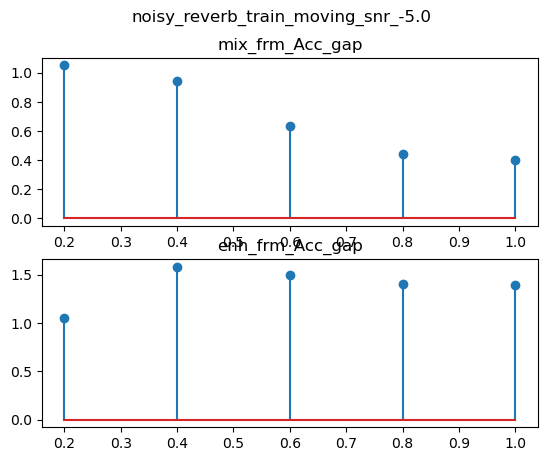

<Figure size 640x480 with 0 Axes>

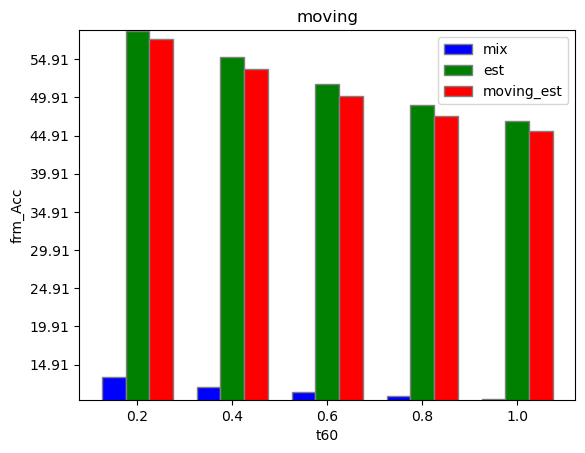

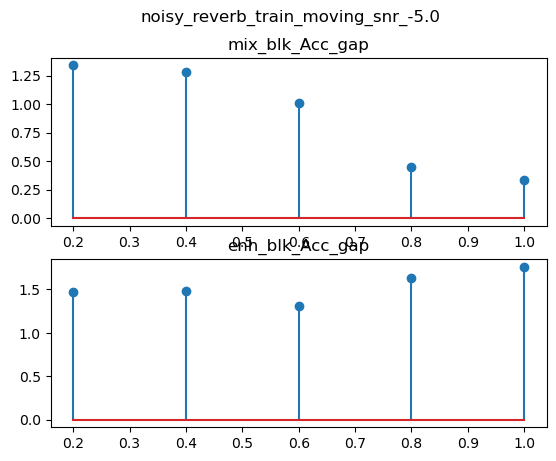

<Figure size 640x480 with 0 Axes>

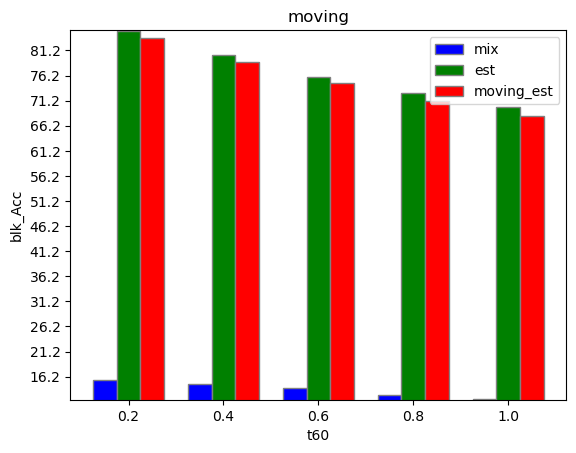

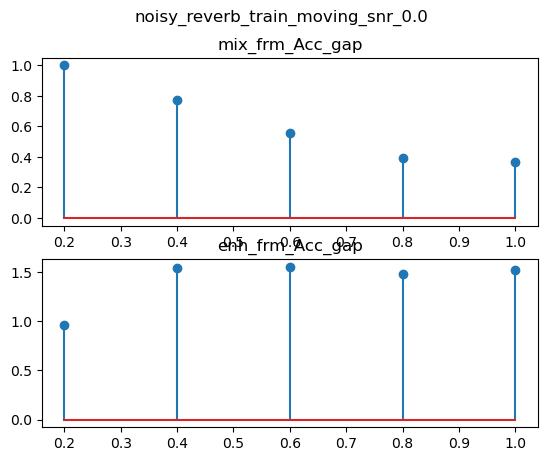

<Figure size 640x480 with 0 Axes>

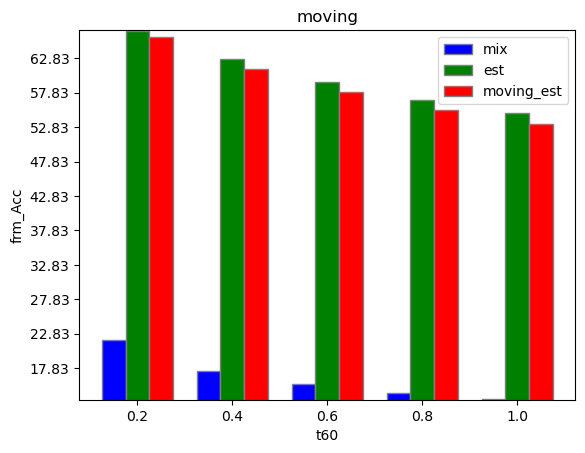

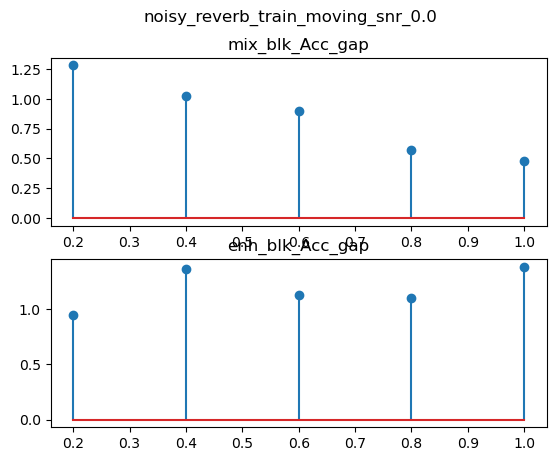

<Figure size 640x480 with 0 Axes>

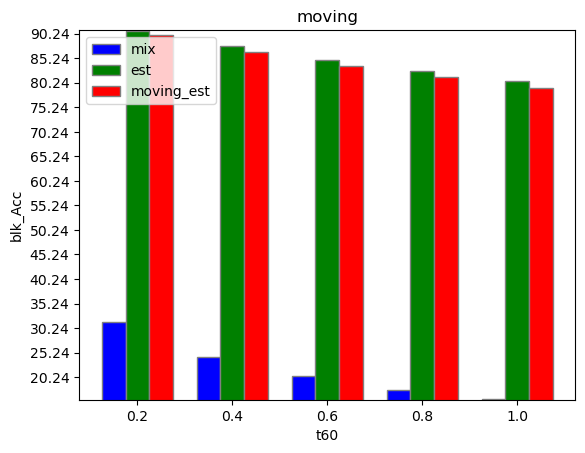

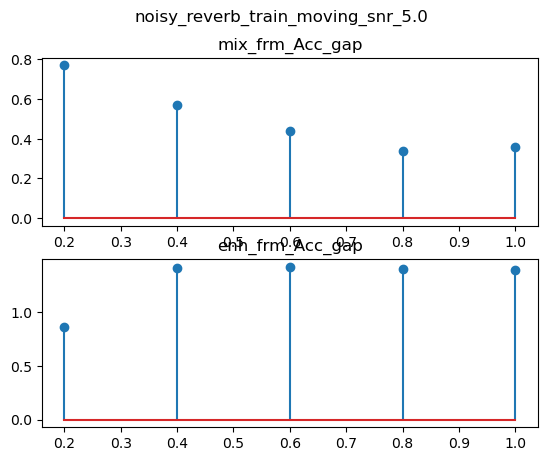

<Figure size 640x480 with 0 Axes>

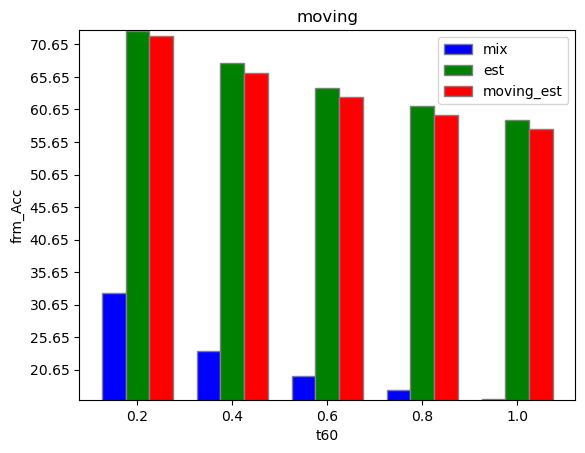

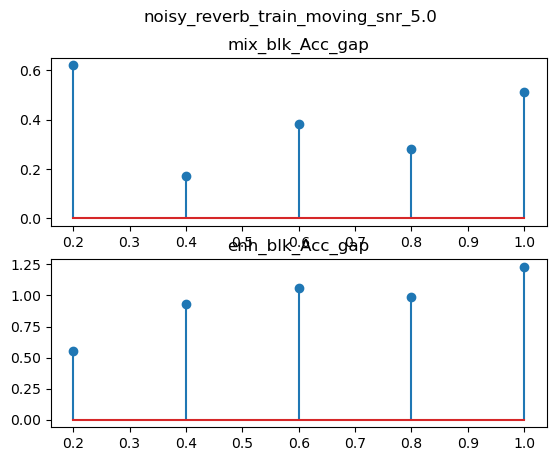

<Figure size 640x480 with 0 Axes>

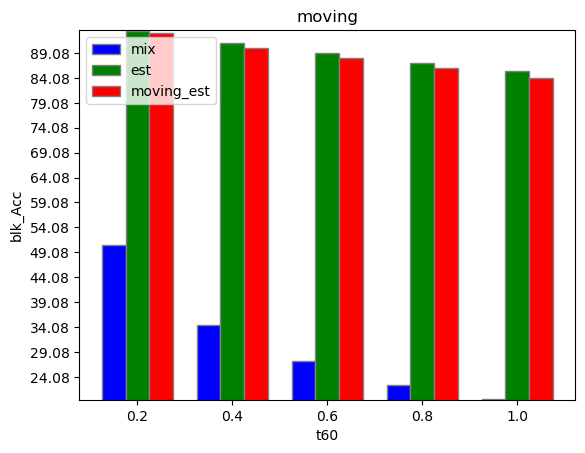

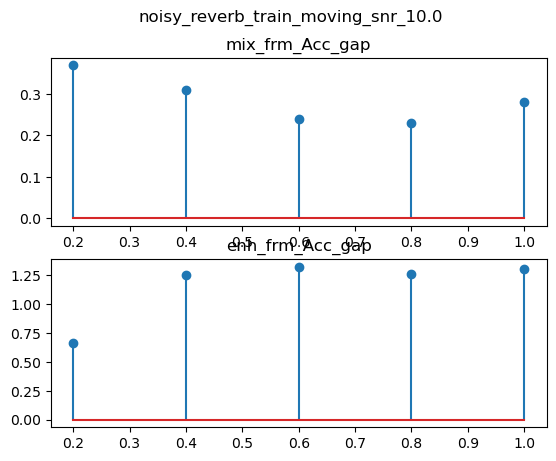

<Figure size 640x480 with 0 Axes>

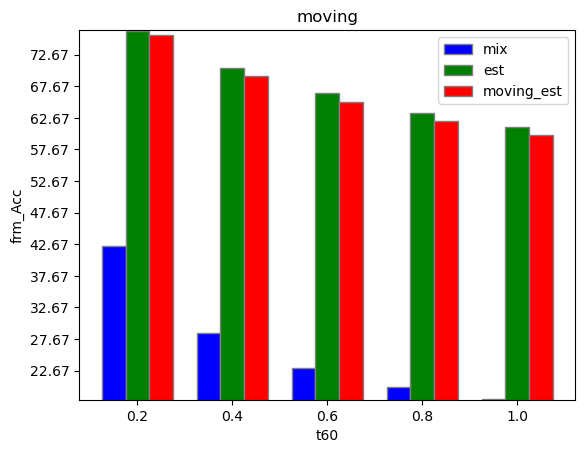

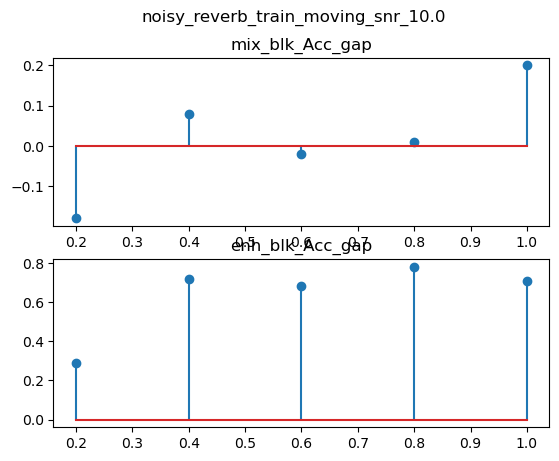

<Figure size 640x480 with 0 Axes>

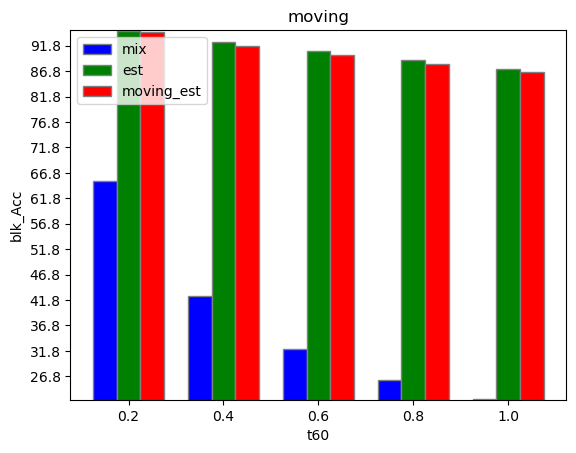

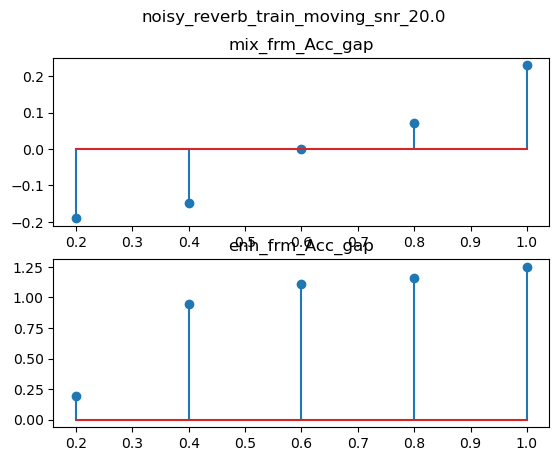

<Figure size 640x480 with 0 Axes>

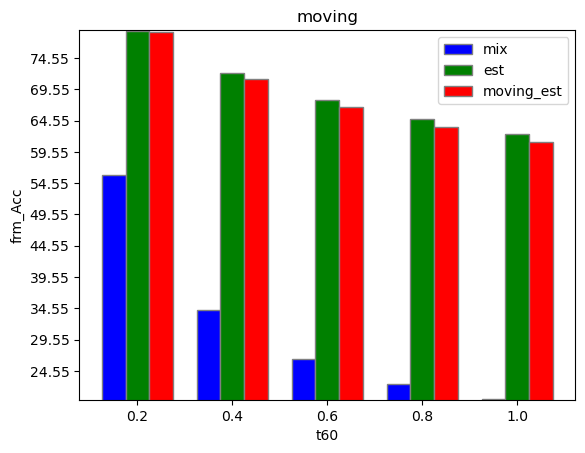

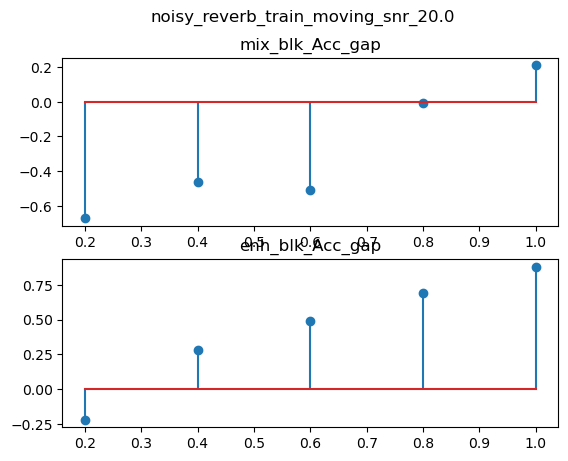

<Figure size 640x480 with 0 Axes>

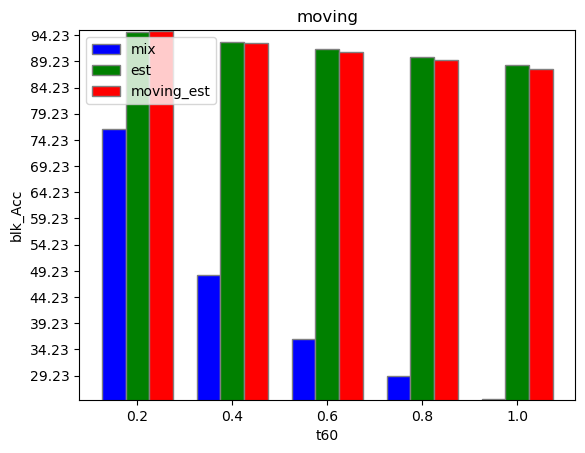

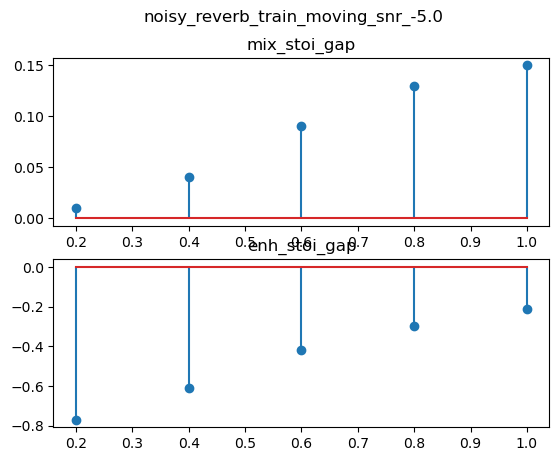

<Figure size 640x480 with 0 Axes>

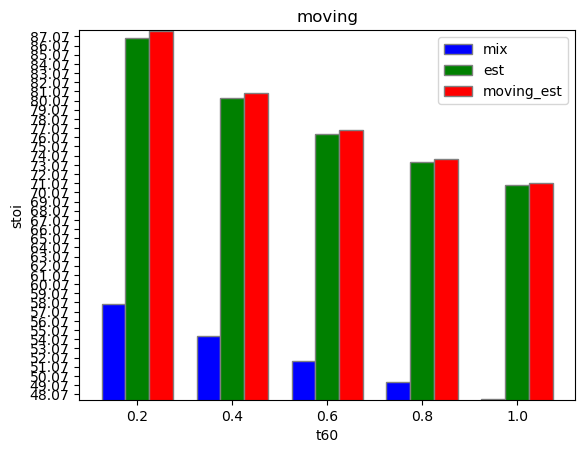

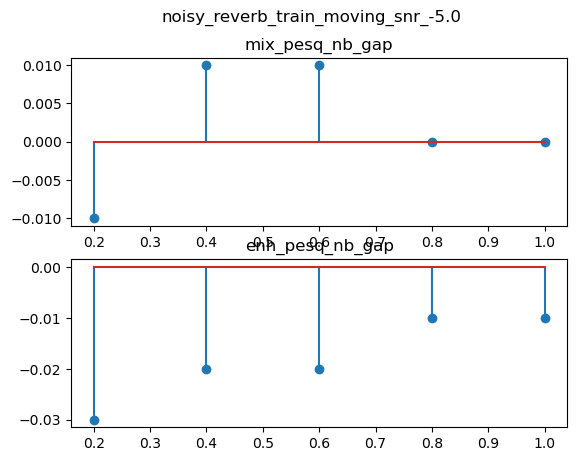

<Figure size 640x480 with 0 Axes>

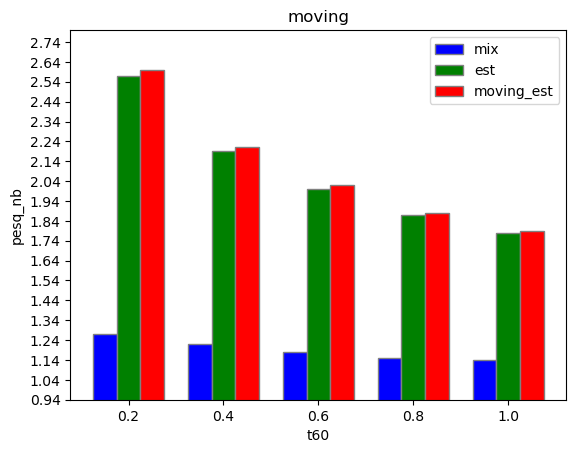

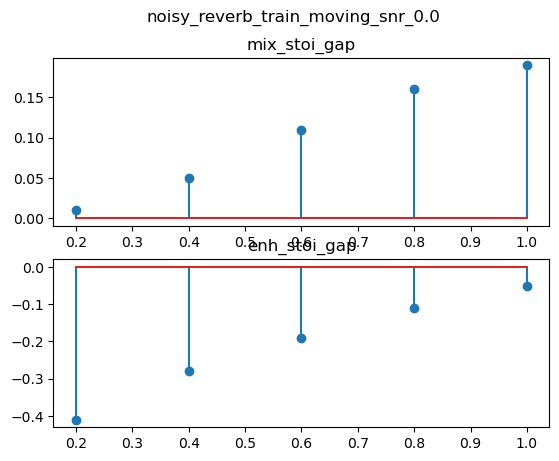

<Figure size 640x480 with 0 Axes>

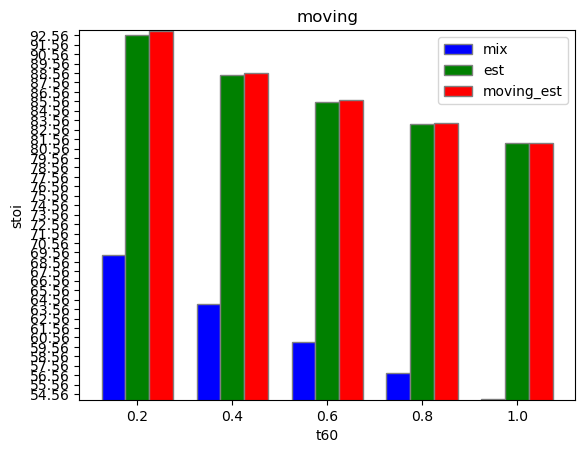

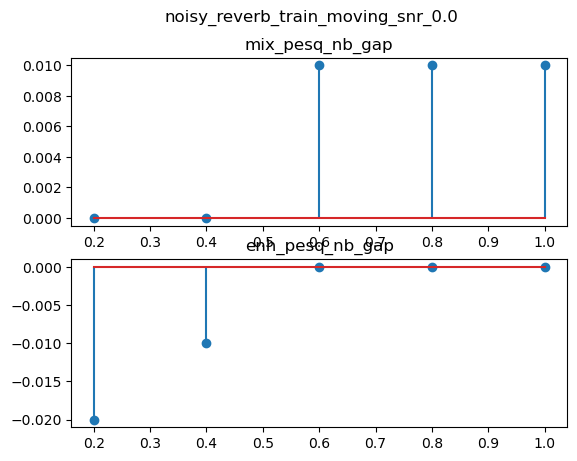

<Figure size 640x480 with 0 Axes>

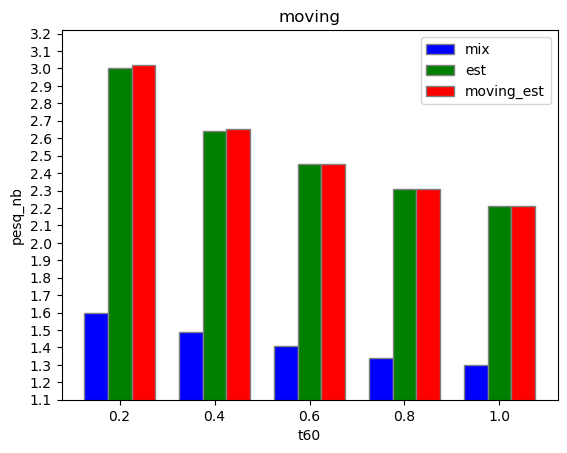

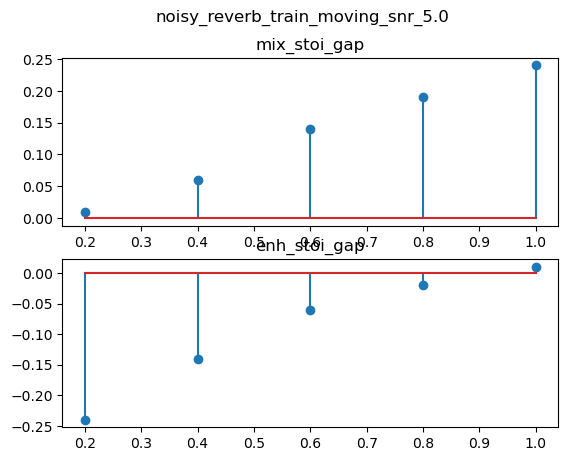

<Figure size 640x480 with 0 Axes>

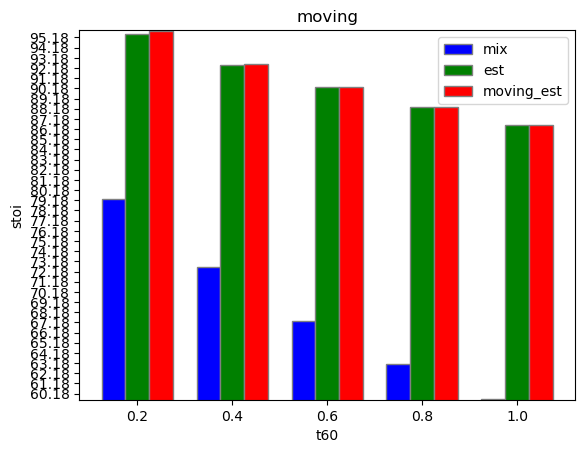

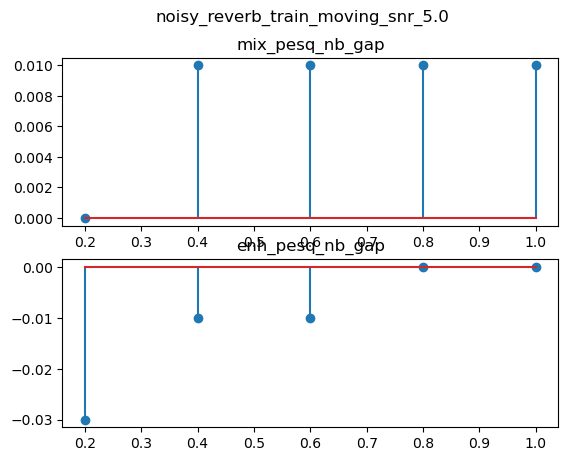

<Figure size 640x480 with 0 Axes>

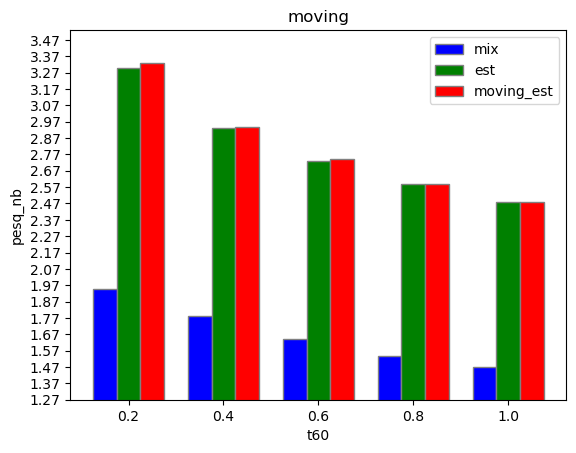

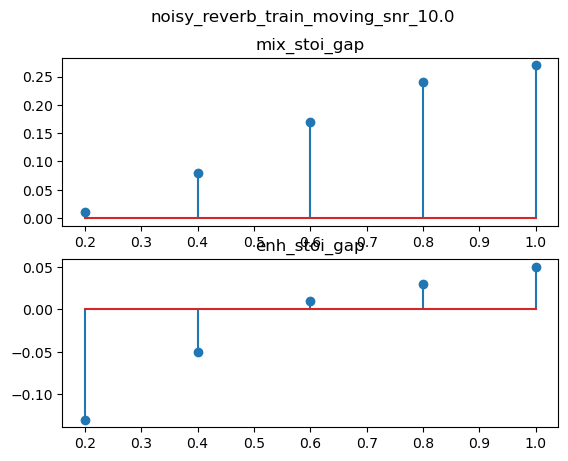

<Figure size 640x480 with 0 Axes>

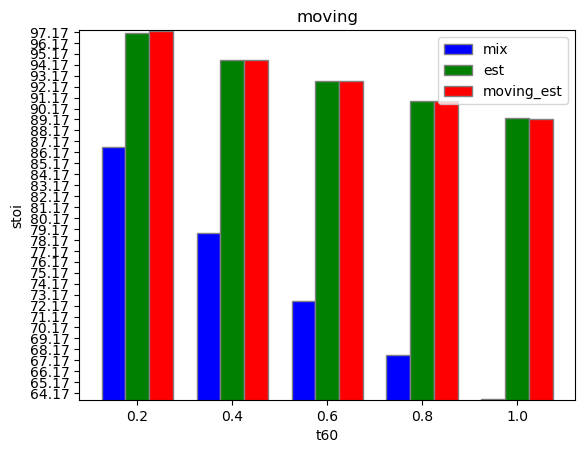

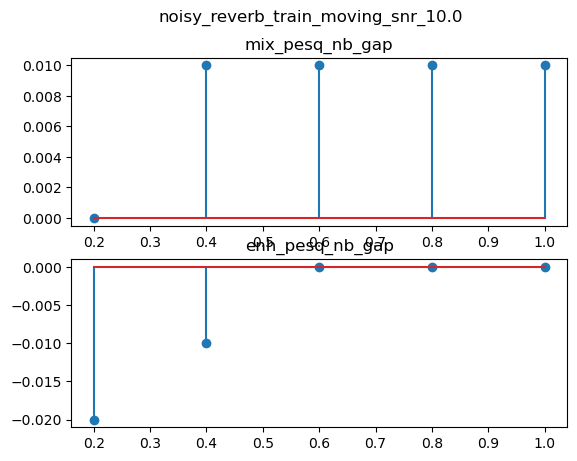

<Figure size 640x480 with 0 Axes>

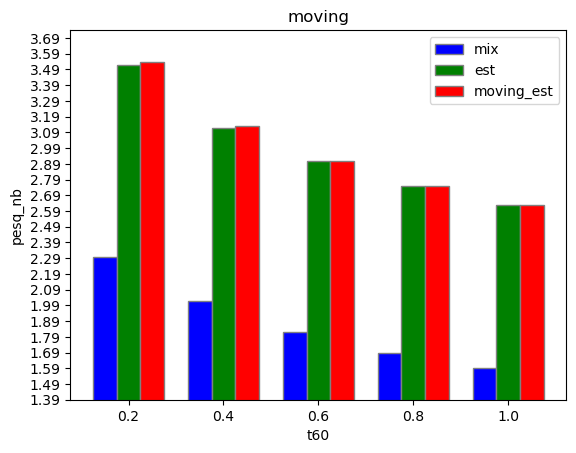

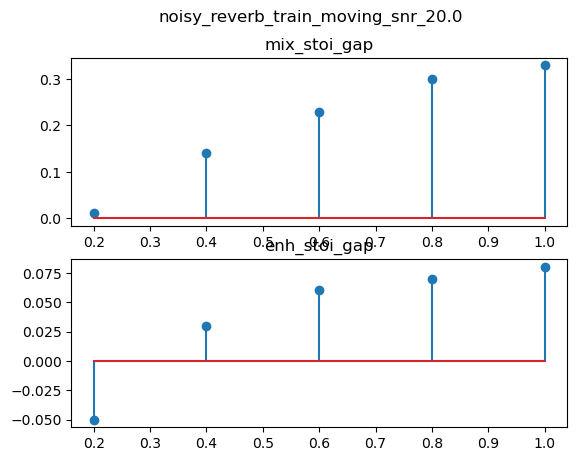

<Figure size 640x480 with 0 Axes>

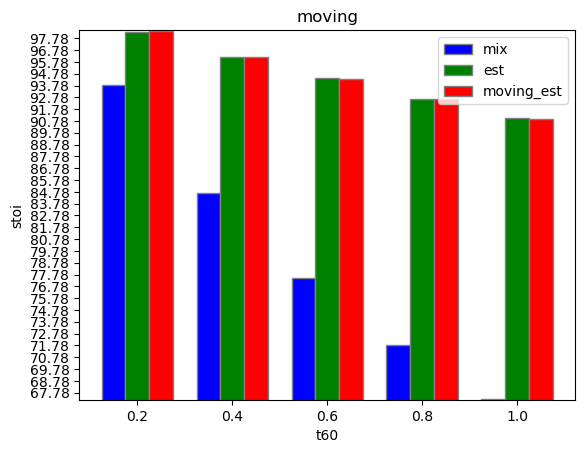

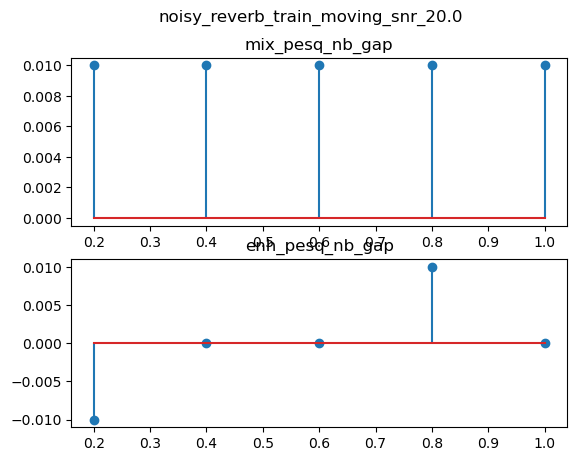

<Figure size 640x480 with 0 Axes>

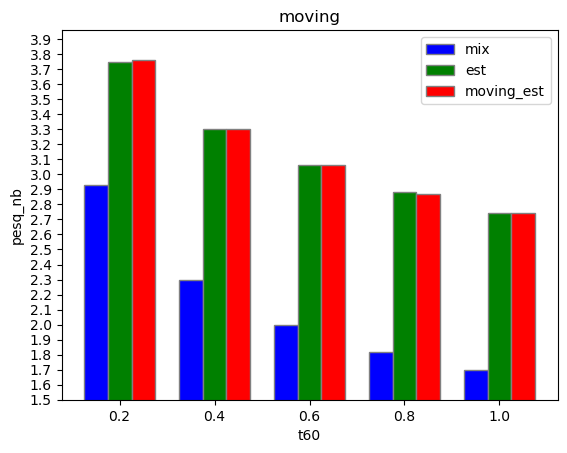

In [66]:
dataset_condition = "noisy_reverb"
mic_idx = 0
train = 'moving'
model_type = "miso"
for comparison_domain in [ "doa", "se"]:
    exp_dict = torch.load(f'../Logs/{dataset_condition}/{dataset_condition}_{comparison_domain}_results.pt')
    _metrics = se_metrics_lst if comparison_domain=="se" else doa_metrics_lst
    if dataset_condition !="noisy_reverb":
        var2, var_list = get_var_list(dataset_condition)
        for metric in _metrics:
            analysis(exp_dict, mic_idx, train, var_list, var2, metric, dataset_condition, comparison_domain, scenarios, model_type)
    else:
        snr_list, t60_list = get_var_list(dataset_condition)
        for snr in snr_list:
            for metric in _metrics:
                analysis(exp_dict, mic_idx, train, t60_list, snr, metric, dataset_condition, comparison_domain, scenarios, model_type)


 

In [8]:
#MIMO

scenarios = ["stationary", "moving"]
#comparison_domain=""
se_metrics_lst = ["stoi", 'pesq_nb']
doa_metrics_lst = ["frm_Acc", "blk_Acc"]
from collections import namedtuple

metrics = namedtuple('metrics', ["mix_stoi", "enh_stoi", "mix_pesq_nb", "enh_pesq_nb", "mix_frm_Acc", "est_frm_Acc", "mix_blk_Acc", "est_blk_Acc"])

/tmp/ipykernel_2347536/2565182360.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


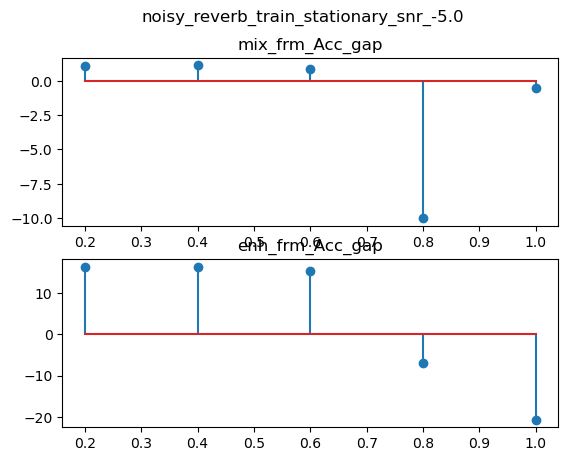

<Figure size 640x480 with 0 Axes>

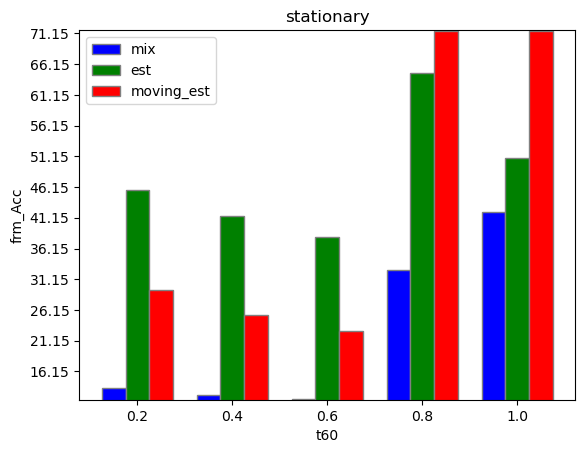

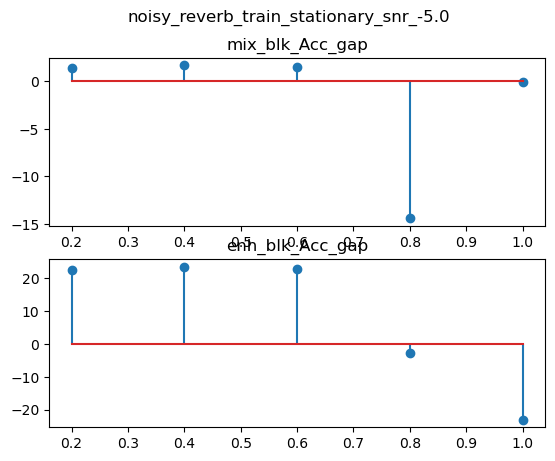

<Figure size 640x480 with 0 Axes>

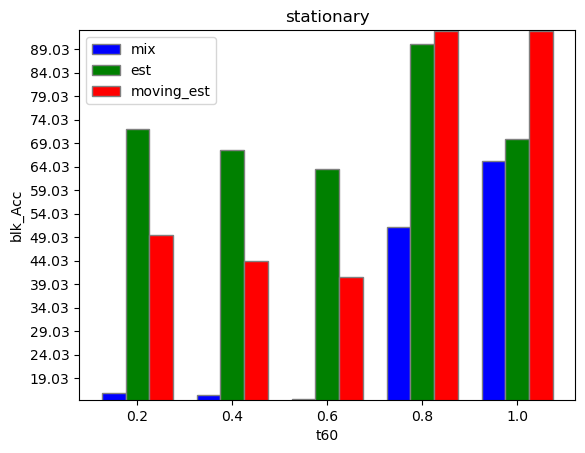

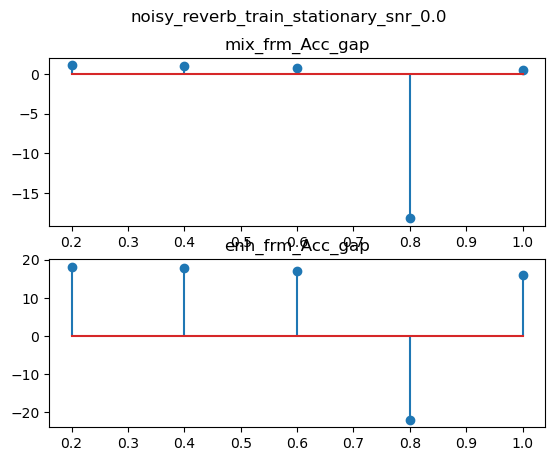

<Figure size 640x480 with 0 Axes>

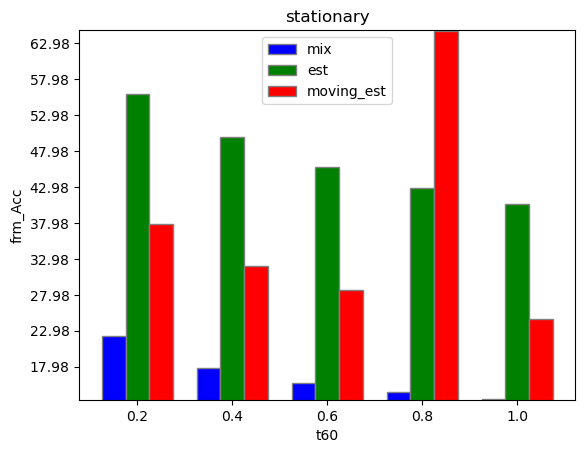

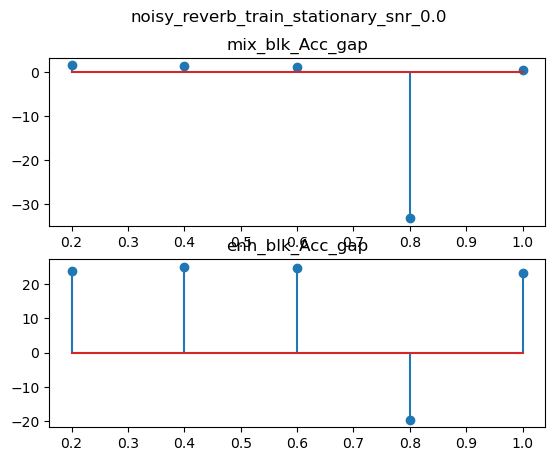

<Figure size 640x480 with 0 Axes>

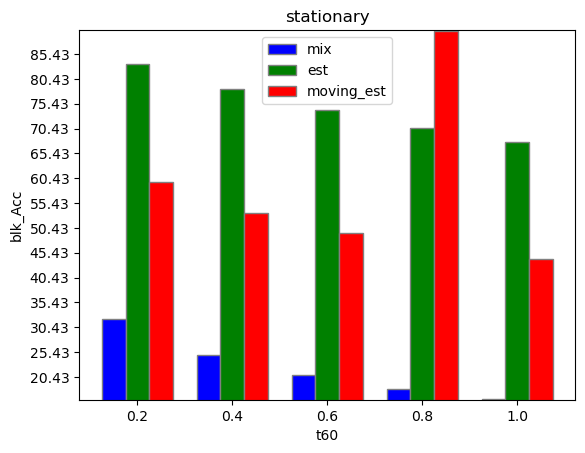

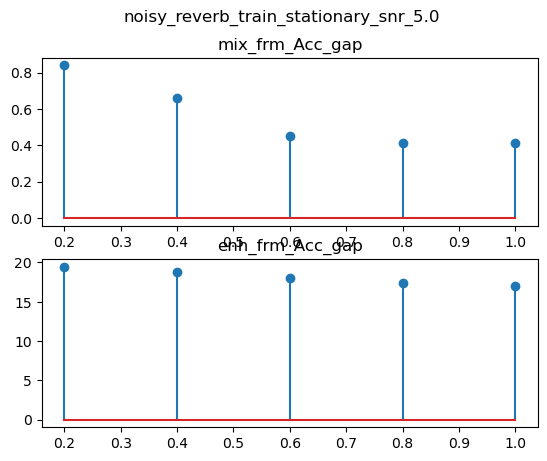

<Figure size 640x480 with 0 Axes>

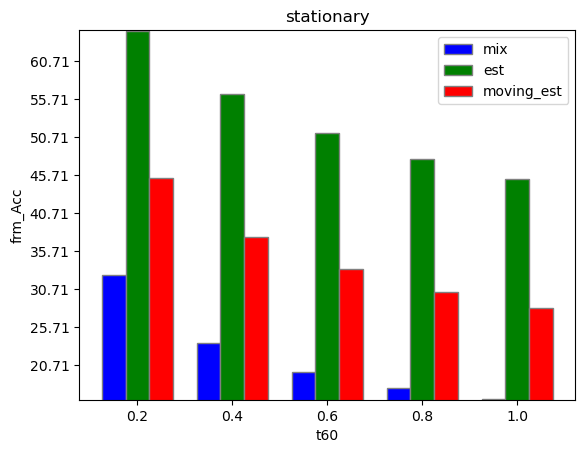

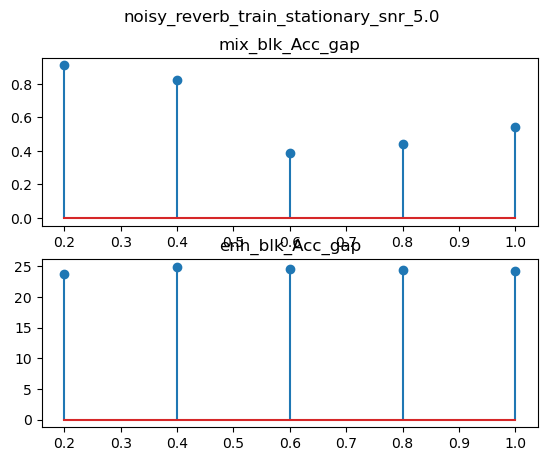

<Figure size 640x480 with 0 Axes>

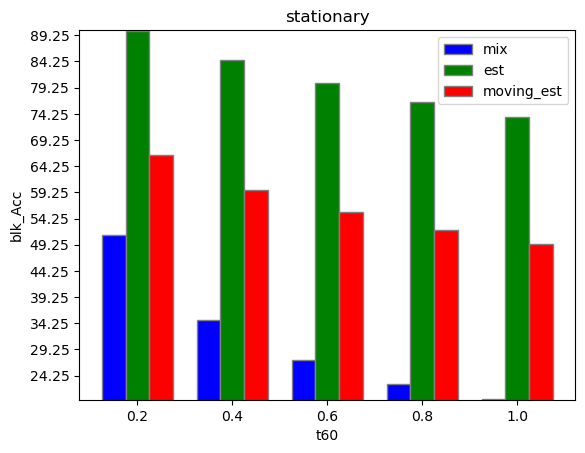

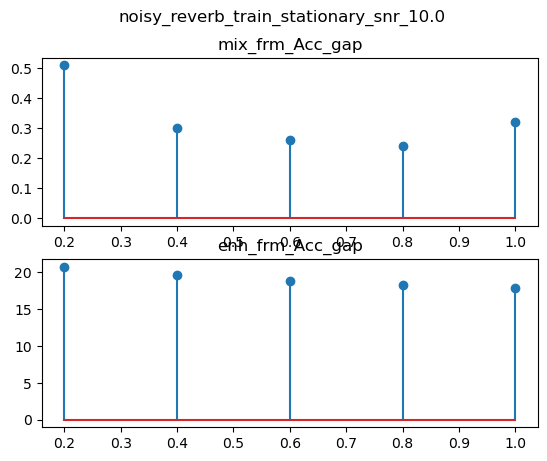

<Figure size 640x480 with 0 Axes>

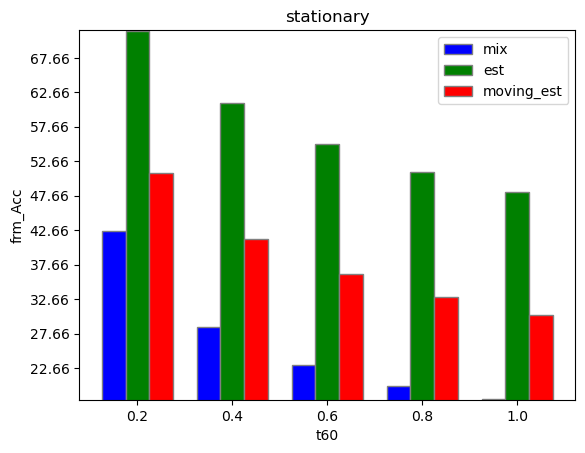

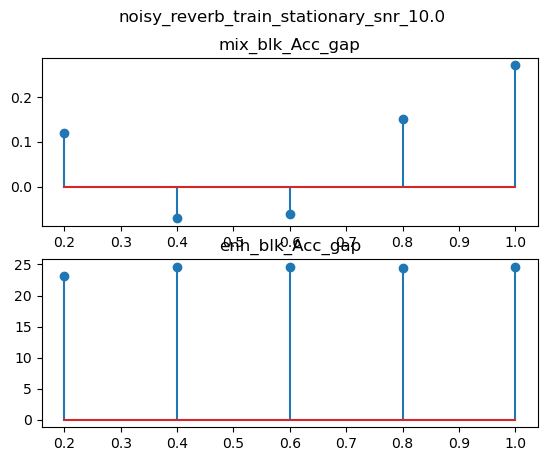

<Figure size 640x480 with 0 Axes>

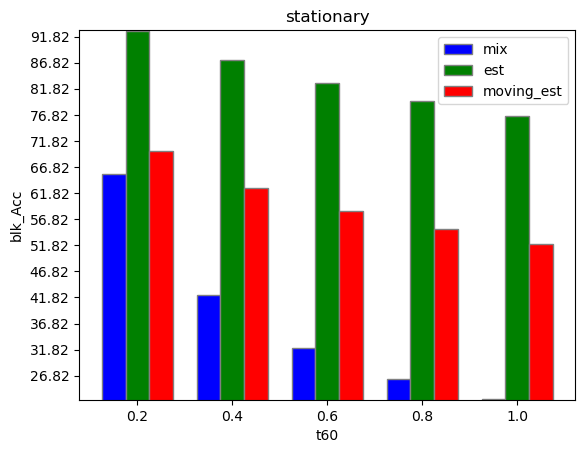

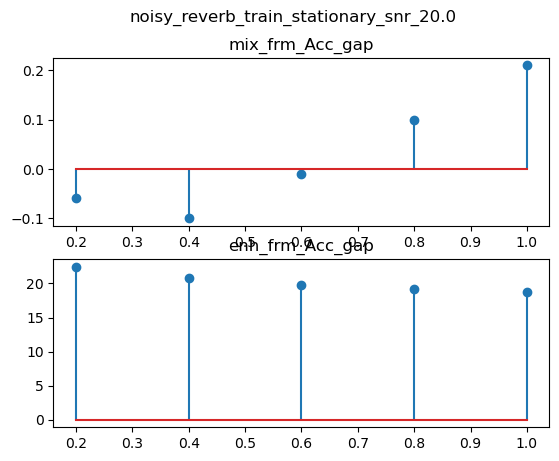

<Figure size 640x480 with 0 Axes>

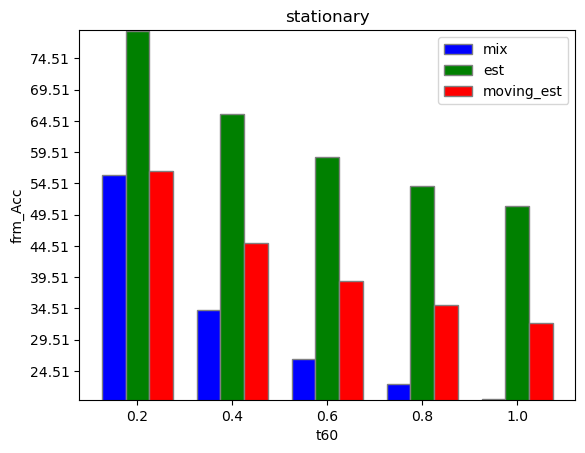

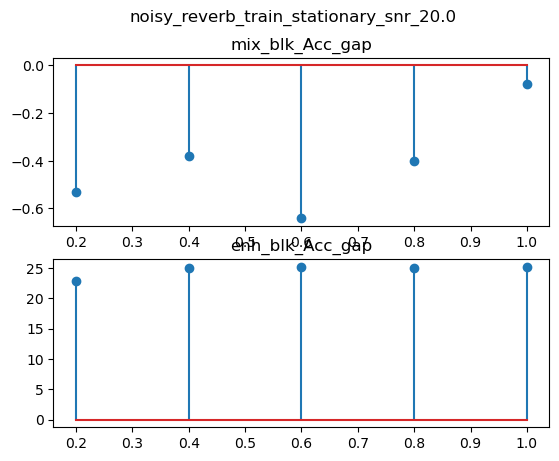

<Figure size 640x480 with 0 Axes>

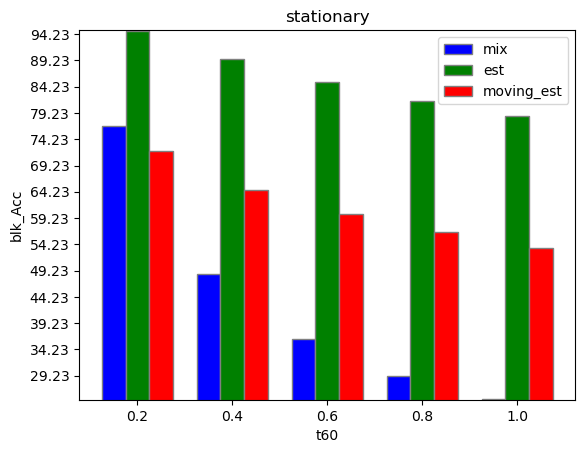

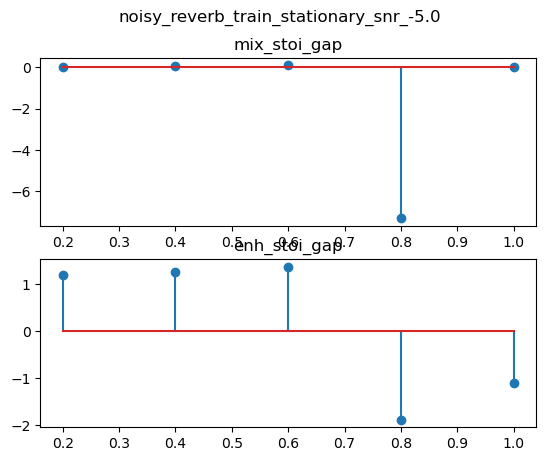

<Figure size 640x480 with 0 Axes>

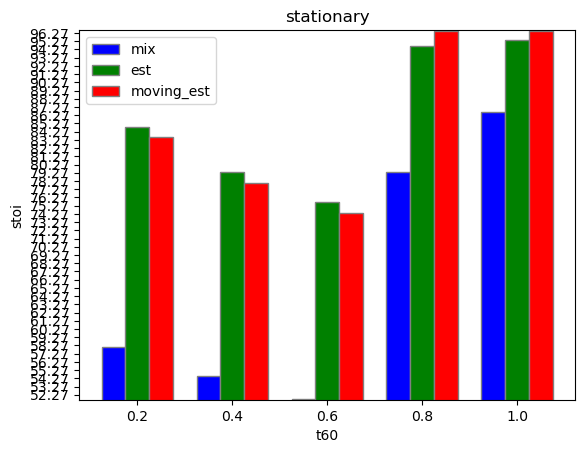

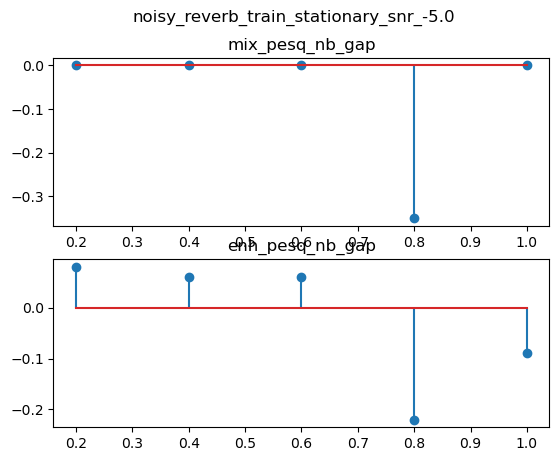

<Figure size 640x480 with 0 Axes>

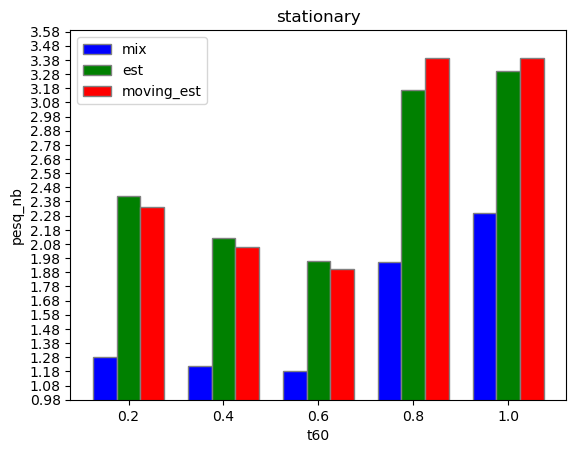

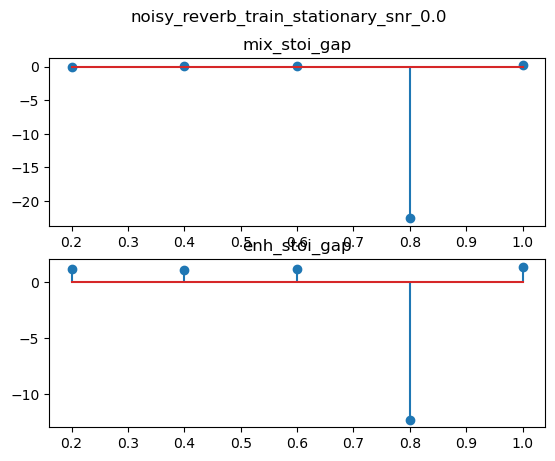

<Figure size 640x480 with 0 Axes>

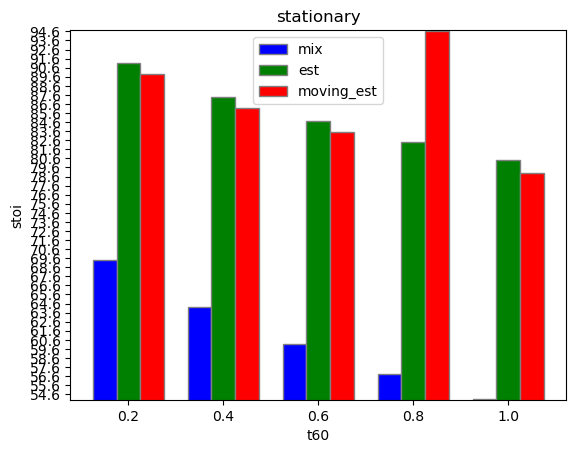

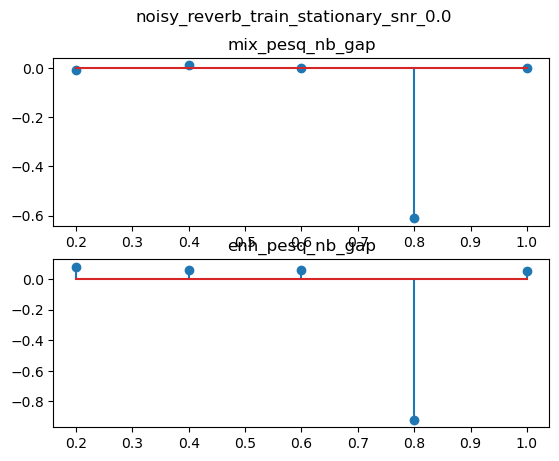

<Figure size 640x480 with 0 Axes>

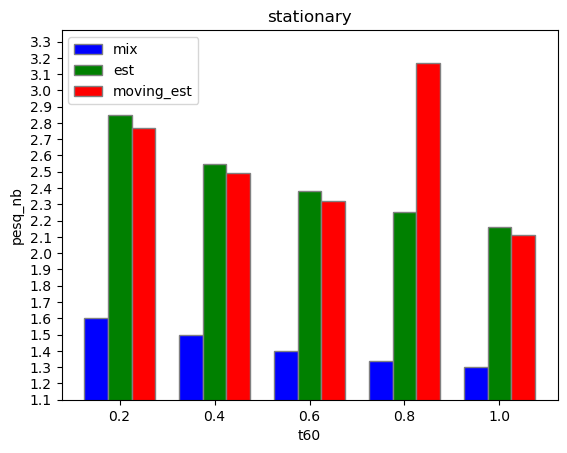

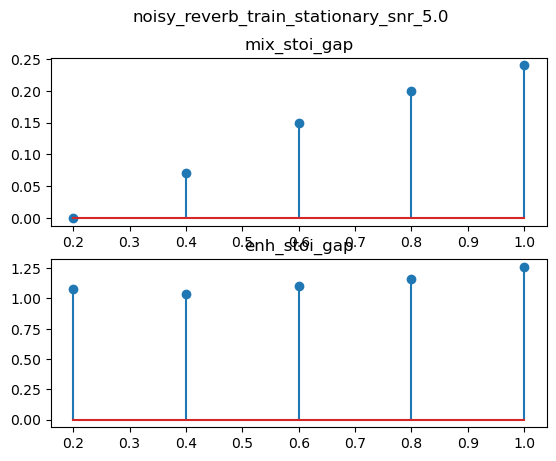

<Figure size 640x480 with 0 Axes>

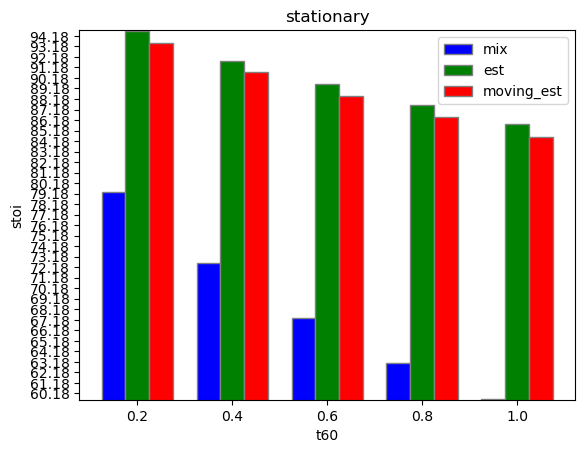

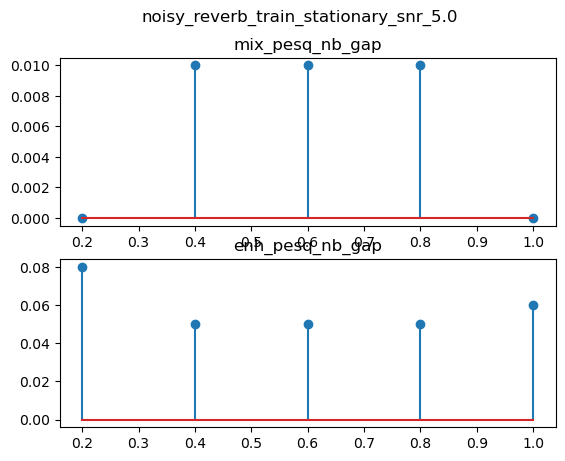

<Figure size 640x480 with 0 Axes>

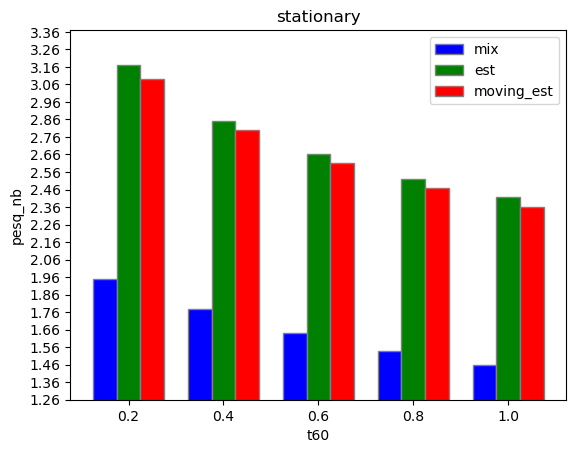

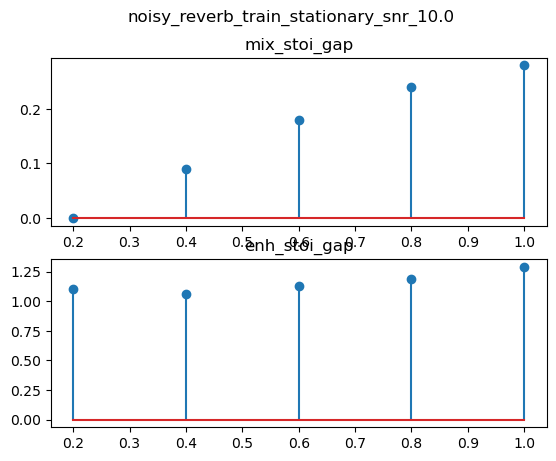

<Figure size 640x480 with 0 Axes>

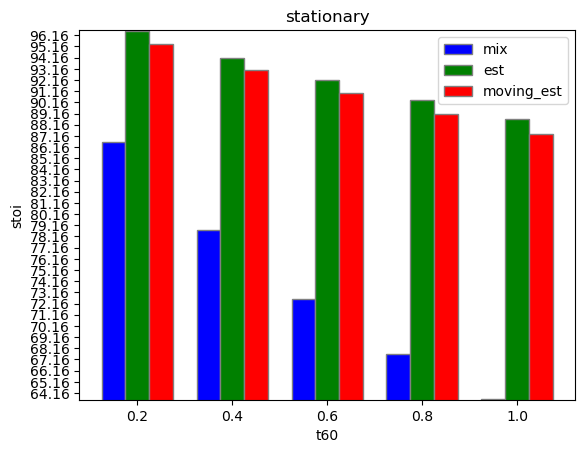

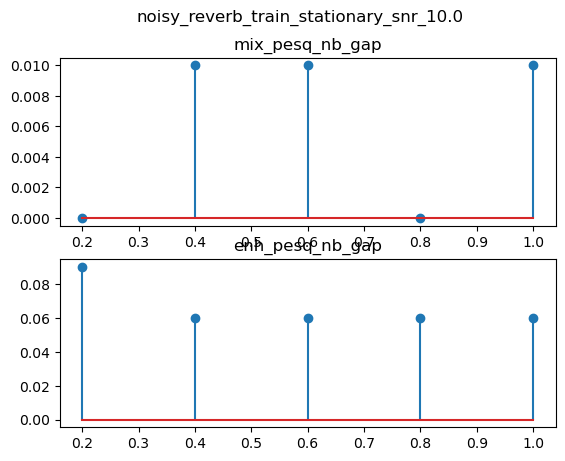

<Figure size 640x480 with 0 Axes>

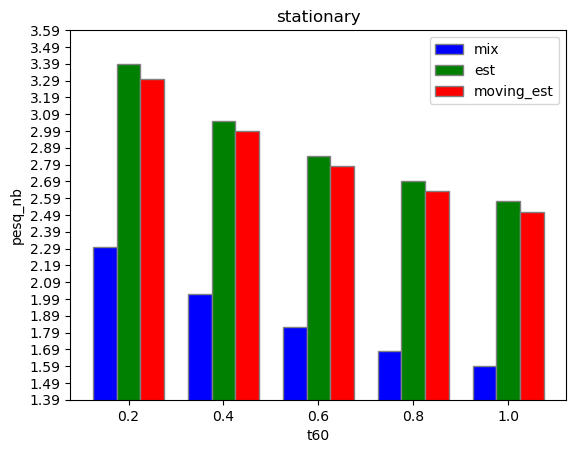

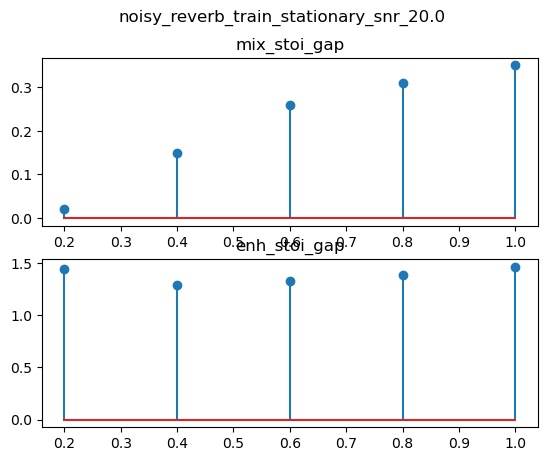

<Figure size 640x480 with 0 Axes>

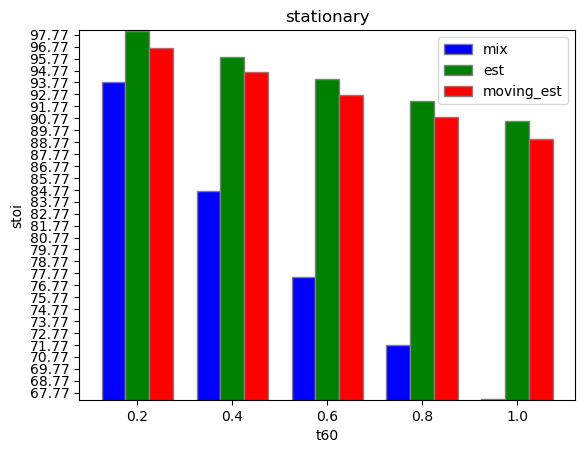

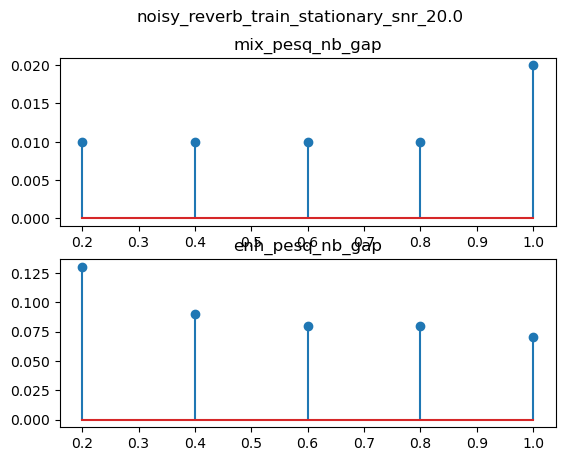

<Figure size 640x480 with 0 Axes>

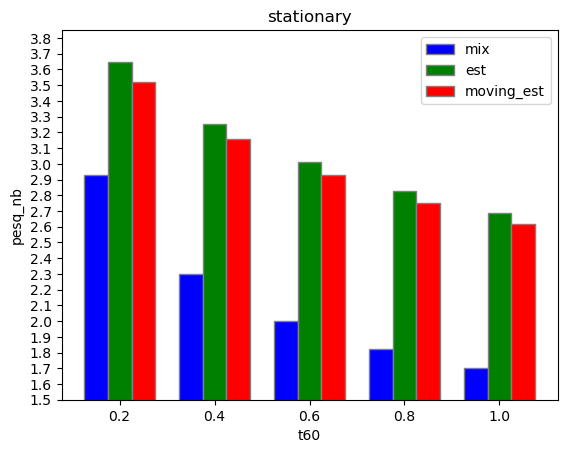

In [9]:
dataset_condition = "noisy_reverb"
train = 'stationary'
mic_idx=-1
model_type = "mimo"
exp_dict = torch.load(f'../Logs/{dataset_condition}/{dataset_condition}_mimo_results.pt')
for comparison_domain in [ "doa", "se"]:
    _metrics = se_metrics_lst if comparison_domain=="se" else doa_metrics_lst
    if dataset_condition !="noisy_reverb":
        var2, var_list = get_var_list(dataset_condition)
        for metric in _metrics:
            analysis(exp_dict, mic_idx, train, var_list, var2, metric, dataset_condition, comparison_domain, scenarios, model_type)
    else:
        snr_list, t60_list = get_var_list(dataset_condition)
        for snr in snr_list:
            for metric in _metrics:
                analysis(exp_dict, mic_idx, train, t60_list, snr, metric, dataset_condition, comparison_domain, scenarios, model_type)


 

In [19]:
exp_dict['train_stationary_test_moving_t60_0.2_snr_5.0']

metrics(mix_stoi='0.7934603532430305', enh_stoi='0.9355315682155089', mix_pesq_nb='1.9517009630583682', enh_pesq_nb='3.0926421248797733', mix_frm_Acc='0.31758004426956177', est_frm_Acc='0.45289888978004456', mix_blk_Acc='0.501732349395752', est_blk_Acc='0.6639872789382935')

In [16]:
len(exp_dict)

75

In [37]:
#MISO vs MIMO


def analysis_miso_mimo(exp_dict_miso, exp_dict_mimo, mic_idx, train, var_list, var2, metric, dataset_condition, comparison_domain, scenarios):

    mix_metric, enh_metric, mvng_metric, mvng_mix_metric = get_metrics(exp_dict_miso, mic_idx=1, train=train, var_list=var_list, var2=var2, metric=metric, dataset_condition=dataset_condition, comparison_domain=comparison_domain, scenarios=scenarios,model_type="miso")
    mix_mimo_metric, enh_mimo_metric, mvng_mimo_metric, mvng_mix_mimo_metric = get_metrics(exp_dict_mimo, mic_idx=-1, train=train, var_list=var_list, var2=var2, metric=metric, dataset_condition=dataset_condition, comparison_domain=comparison_domain, scenarios=scenarios,model_type="mimo")

    mix_metric_gap = perf_gap(mix_metric, mvng_mix_metric)
    enh_metric_gap = perf_gap(enh_metric, enh_mimo_metric)
    mvng_metric_gap = perf_gap(mvng_metric, mvng_mimo_metric)


    plt_title = f'{dataset_condition}_train_{train}' if dataset_condition!="noisy_reverb" else f'{dataset_condition}_train_{train}_snr_{var2}'
    plt.figure()
    plt.suptitle(plt_title)

    plt.subplot(3,1,1)
    plt.stem(var_list, mix_metric_gap)
    plt.title(f'mix_{metric}_gap')

    plt.subplot(3,1,2)
    plt.stem(var_list, enh_metric_gap)
    plt.title(f'enh_{metric}_gap')

    plt.subplot(3,1,3)
    plt.stem(var_list, mvng_metric_gap)
    plt.title(f'mvng_{metric}_gap')

 

    plt.figure()
    str_var_list = [str(x) for x in var_list]
    bar_plot(mix_metric, enh_metric, enh_mimo_metric, x_axis_lst = str_var_list, ylabel=metric, title=train , bar_plot_labels=[f"{dataset_condition}", "miso", "mimo"])
    bar_plot(mix_metric, mvng_metric, mvng_mimo_metric, x_axis_lst = str_var_list, ylabel=metric, title=train, bar_plot_labels=[f"{dataset_condition}", "mvng_miso", "mvng_mimo"] )



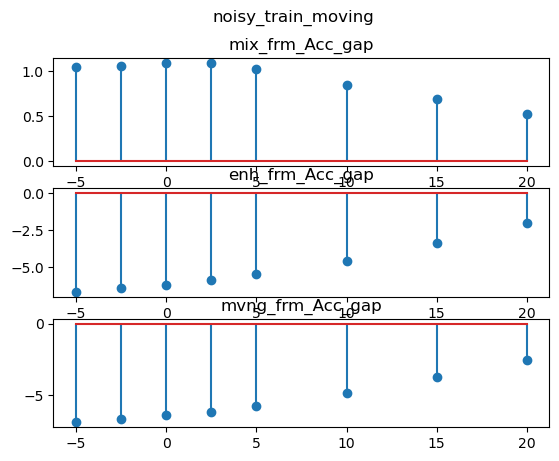

<Figure size 640x480 with 0 Axes>

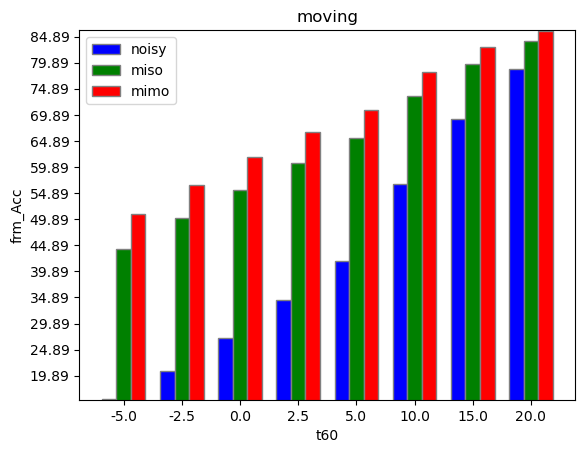

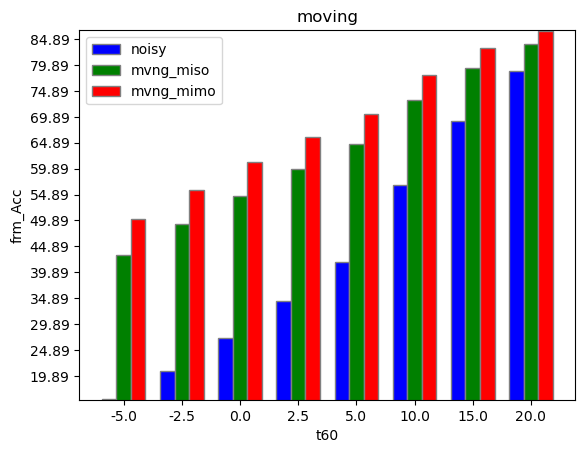

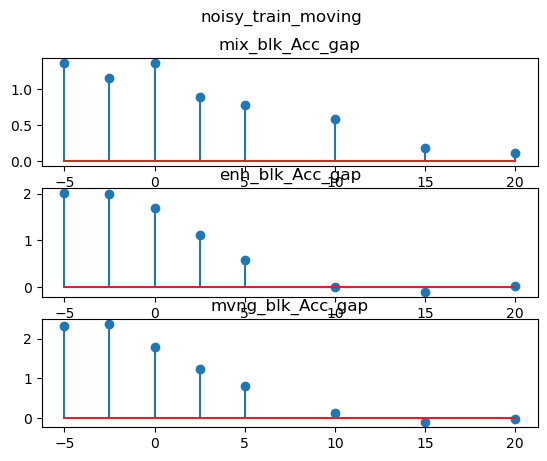

<Figure size 640x480 with 0 Axes>

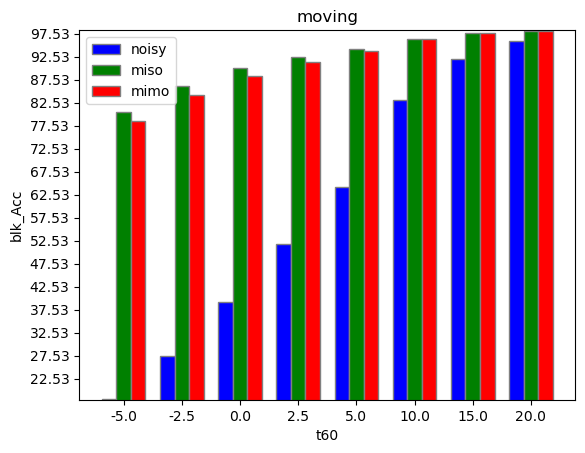

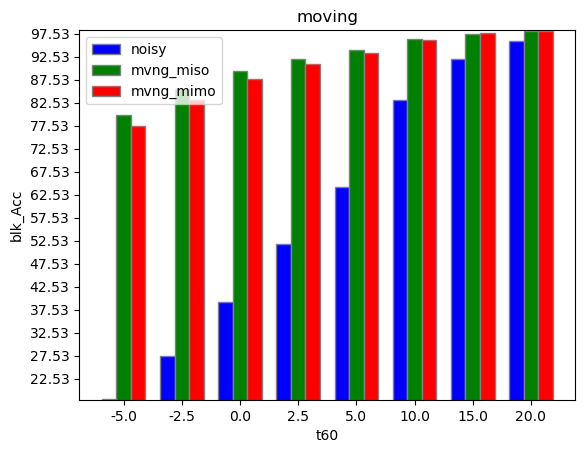

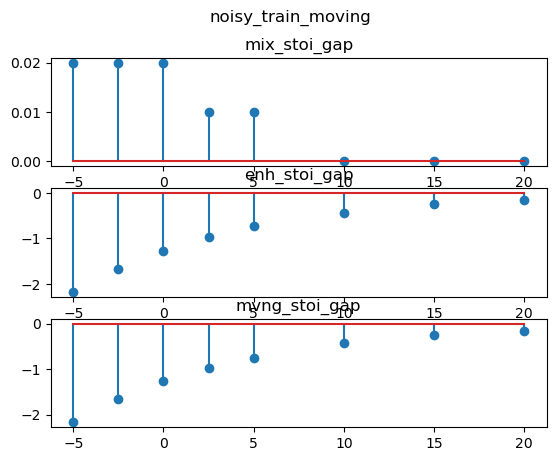

<Figure size 640x480 with 0 Axes>

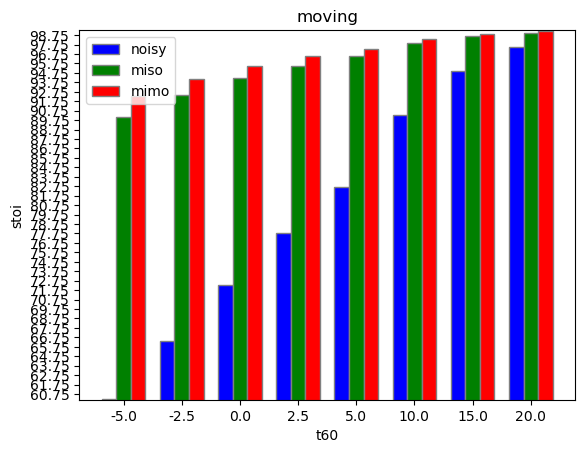

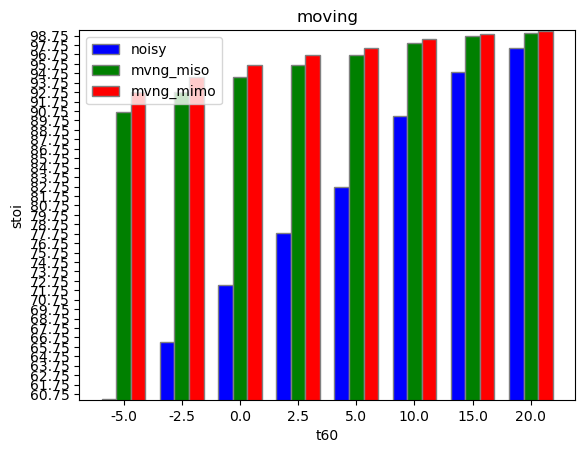

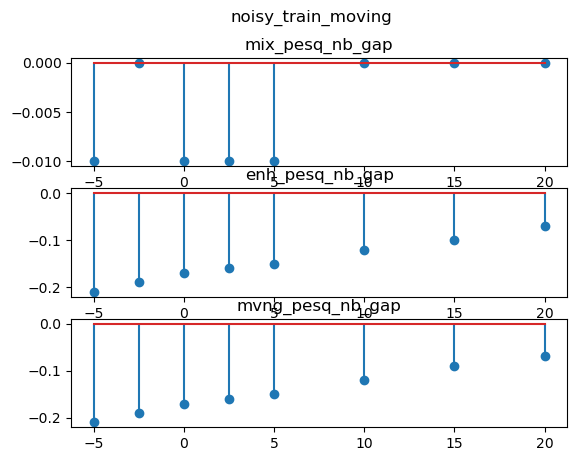

<Figure size 640x480 with 0 Axes>

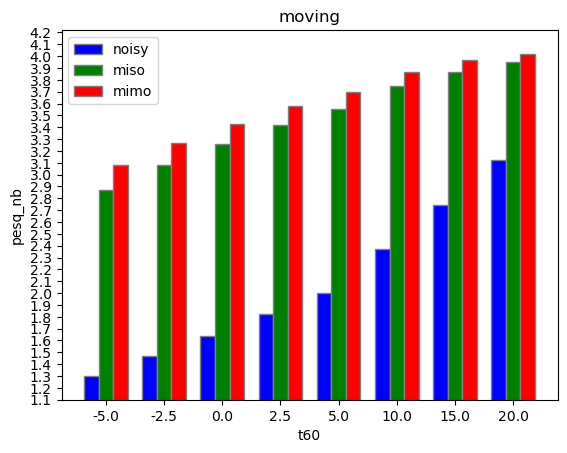

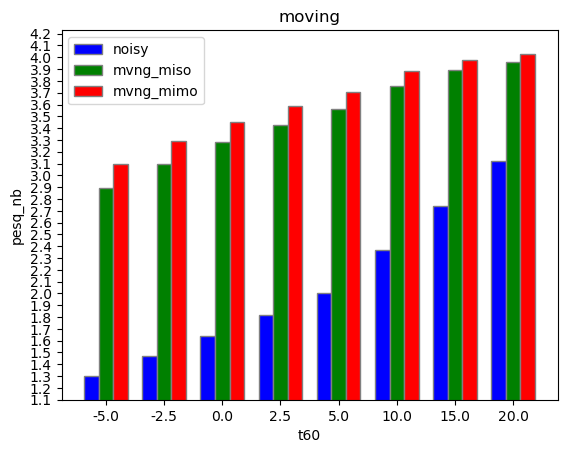

In [42]:
dataset_condition = "noisy_reverb"
train = 'stationary'
mic_idx=-1

doa_metrics = namedtuple('doa_metrics', ["mix_frm_Acc", "est_frm_Acc", "mix_blk_Acc", "est_blk_Acc"])


metrics = namedtuple('metrics', ["mix_stoi", "enh_stoi", "mix_pesq_nb", "enh_pesq_nb", "mix_frm_Acc", "est_frm_Acc", "mix_blk_Acc", "est_blk_Acc"])
exp_dict_mimo = torch.load(f'../Logs/{dataset_condition}/{dataset_condition}_mimo_results.pt')
metrics = namedtuple('metrics', ["mix_stoi", "enh_stoi", "mix_pesq_nb", "enh_pesq_nb"])
for comparison_domain in [ "doa", "se"]:
    
    _metrics = se_metrics_lst if comparison_domain=="se" else doa_metrics_lst
    exp_dict_miso = torch.load(f'../Logs/{dataset_condition}/{dataset_condition}_{comparison_domain}_results.pt')
    
    if dataset_condition !="noisy_reverb":
        var2, var_list = get_var_list(dataset_condition)
        for metric in _metrics:
            analysis_miso_mimo(exp_dict_miso, exp_dict_mimo, mic_idx, train, var_list, var2, metric, dataset_condition, comparison_domain, scenarios)
    else:
        snr_list, t60_list = get_var_list(dataset_condition)
        for snr in snr_list:
            for metric in _metrics:
                analysis(exp_dict, mic_idx, train, t60_list, snr, metric, dataset_condition, comparison_domain, scenarios, model_type)


 